# **Retail Stock Market Behavior — Data Preprocessing & EDA**

In [830]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("meesalasreesainath/online-retail")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'online-retail' dataset.
Path to dataset files: /kaggle/input/online-retail


# **Read the Data**

  This dataset contains transaction records from a UK-based online retail store, covering the period between **December 1, 2010** and **December 9, 2011**.
  **Source**: [UCI Machine Learning Repository – Online Retail Dataset](http://archive.ics.uci.edu/ml/datasets/Online+Retail)


In [831]:
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        break

# Load the dataset
df = pd.read_csv(csv_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom


In [832]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# **Basic exploration and data preprocessing**

Let's have a look how does the data looks like:

In [833]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26:00,3.39,17850.0,United Kingdom


## **Number of rows and columns in data set**

In [834]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  541909
Number of columns in dataset is:  8


## **Basic Information and Missing Values**

Before cleaning, it's important to explore column datatypes and identify missing values.
This step helps us decide which attributes require conversion or imputation.

In [835]:
df.info()
print("\nMissing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing values per column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [836]:
print("Number of unique customers IDs:", len(df['CustomerID'].unique().tolist()))

Number of unique customers IDs: 4373


# **Remove Duplicate Records**

Duplicate records lead to inflated counts and incorrect metrics.
We remove them and track the exact number dropped to maintain transparency.

In [837]:
initial = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial - df.shape[0]}")
print("Shape after cleaning:", df.shape)


Duplicates removed: 5268
Shape after cleaning: (536641, 8)


# **Handle Missing Customer IDs**

The CustomerID field is crucial for segmentation and behavioral analysis.
Records missing this field are removed, while others are retained.

In [838]:
before = df.shape[0]
df.dropna(subset=["CustomerID"], inplace=True)
print(f"Removed rows with missing CustomerID: {before - df.shape[0]}")
print("Shape after:", df.shape)


Removed rows with missing CustomerID: 135037
Shape after: (401604, 8)


# **Remove Cancelled Invoices**

Invoices beginning with “C” represent cancelled transactions.
We exclude them to prevent double-counting and revenue misrepresentation.

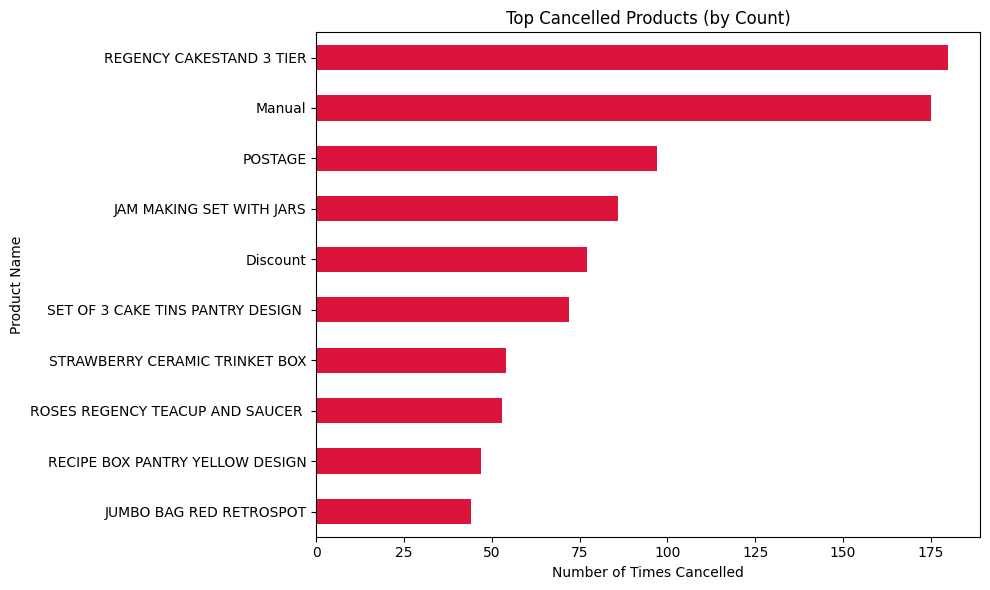

In [839]:
# Filter cancellations
cancellations = df[df['InvoiceNo'].astype(str).str.startswith('C')]

# Count how many times each product was cancelled
cancel_counts = (
    cancellations['Description']
    .value_counts()
    .head(10)
)

# Plot
plt.figure(figsize=(10,6))
cancel_counts.sort_values().plot(kind='barh', color='crimson')

plt.title("Top Cancelled Products (by Count)")
plt.xlabel("Number of Times Cancelled")
plt.ylabel("Product Name")

plt.tight_layout()
plt.show()


In [840]:
before = df.shape[0]
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
print(f"Removed cancelled invoices: {before - df.shape[0]}")

Removed cancelled invoices: 8872


# **Clean Invalid Quantity or Unit Price**

Transactions with negative or zero values for quantity or unit price are logically invalid.
These are filtered out to ensure analytical consistency.

In [841]:
before = df.shape[0]
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
print(f"Removed invalid Quantity/Price rows: {before - df.shape[0]}")


Removed invalid Quantity/Price rows: 40


# **Convert Data Types**

Converting data types ensures accurate computation.
Dates are converted to datetime, and CustomerID to integer for efficient processing.

In [842]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["CustomerID"] = df["CustomerID"].astype(int)


In [843]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


# **Create New Analytical Features**

We add engineered columns to enrich the dataset.
These include total transaction value and time components, essential for temporal and revenue analysis.

In [844]:
df["TotalPrice"] = round(df["Quantity"] * df["UnitPrice"],3)
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
df["Hour"] = df["InvoiceDate"].dt.hour
print("New features added successfully.")


New features added successfully.


In [845]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8


# **Handle Outliers Using IQR Method**

Outliers can distort mean and variance.
Using the Interquartile Range (IQR), we identify and remove extreme Quantity and UnitPrice values.

Quantity     6.00
UnitPrice    1.95
Name: 0.5, dtype: float64
Outliers removed: 59458


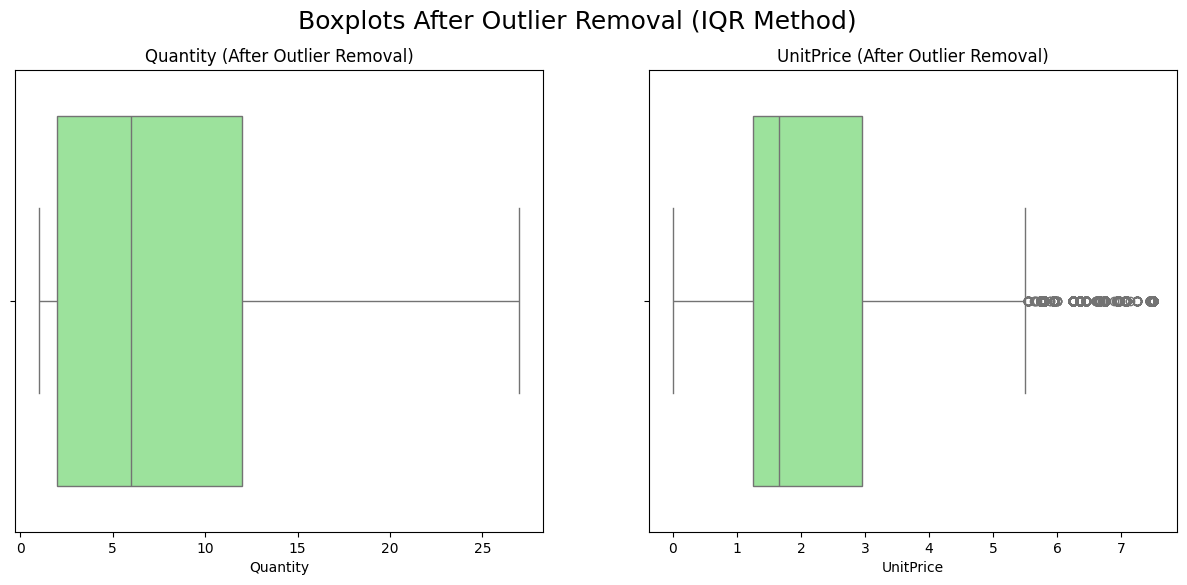

In [846]:
# OUTLIER DETECTION USING IQR METHOD

import matplotlib.pyplot as plt
import seaborn as sns

df_before = df.copy()

# 1. CALCULATE IQR

Q1 = df_before[['Quantity', 'UnitPrice']].quantile(0.25)
Q3 = df_before[['Quantity', 'UnitPrice']].quantile(0.75)
print(df_before[['Quantity', 'UnitPrice']].quantile(0.50))
IQR = Q3 - Q1

# 2. REMOVE OUTLIERS

condition = ~(
    (df_before['Quantity'] < (Q1['Quantity'] - 1.5 * IQR['Quantity'])) |
    (df_before['Quantity'] > (Q3['Quantity'] + 1.5 * IQR['Quantity'])) |
    (df_before['UnitPrice'] < (Q1['UnitPrice'] - 1.5 * IQR['UnitPrice'])) |
    (df_before['UnitPrice'] > (Q3['UnitPrice'] + 1.5 * IQR['UnitPrice']))
)

df_after = df_before[condition].copy()

print(f"Outliers removed: {df_before.shape[0] - df_after.shape[0]}")


# BOX PLOTS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Boxplots After Outlier Removal (IQR Method)', fontsize=18)

sns.boxplot(x=df_after['Quantity'], ax=axes[0], color='lightgreen', showfliers=True)
axes[0].set_title('Quantity (After Outlier Removal)')

sns.boxplot(x=df_after['UnitPrice'], ax=axes[1], color='lightgreen', showfliers=True)
axes[1].set_title('UnitPrice (After Outlier Removal)')

# Update df
df = df_after


In [847]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Normalization and Scaling**
We standardise the numerical features to have a mean of 0 and standard deviation of 1.

--- Feature Distributions: Before vs After Scaling ---


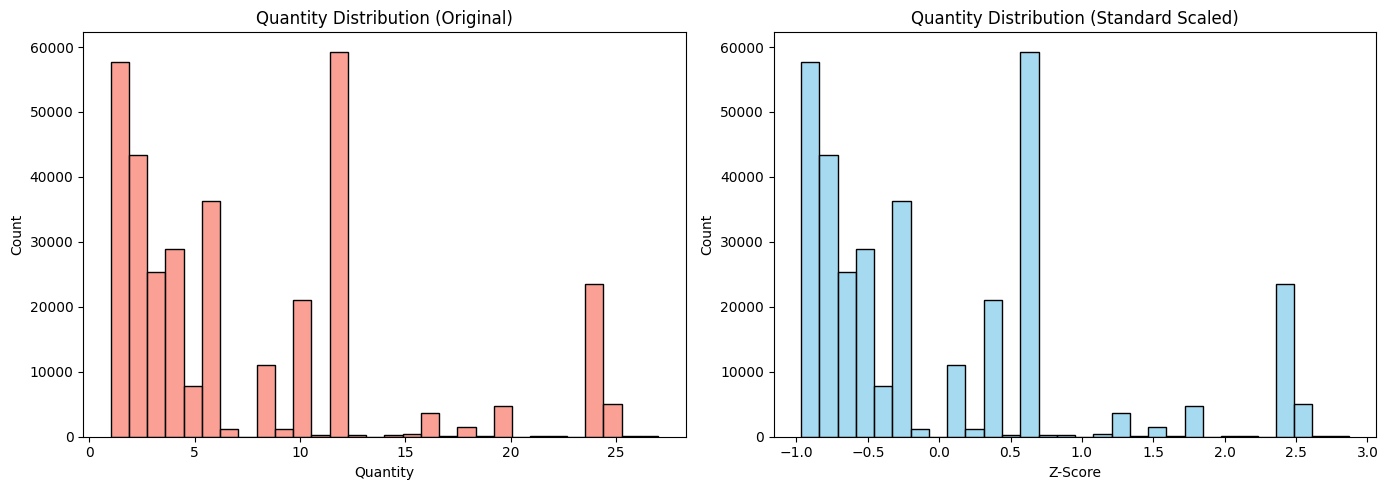

In [848]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Quantity', 'UnitPrice', 'TotalPrice']]),
                         columns=['Quantity', 'UnitPrice', 'TotalPrice'],
                         index=df.index)

print("--- Feature Distributions: Before vs After Scaling ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before (Quantity)
sns.histplot(df['Quantity'], bins=30, ax=axes[0], color='salmon')
axes[0].set_title('Quantity Distribution (Original)')

# After (Quantity)
sns.histplot(df_scaled['Quantity'], bins=30, ax=axes[1], color='skyblue')
axes[1].set_title('Quantity Distribution (Standard Scaled)')
axes[1].set_xlabel('Z-Score')

plt.tight_layout()
plt.show()

In [849]:
df.shape

(333234, 13)

# **Standardize Country Names**

Country names are normalized to a consistent title case format to prevent grouping mismatches.

In [850]:
df["Country"] = df["Country"].str.strip().str.title()
print("Unique countries:", df["Country"].nunique())


Unique countries: 37


# **Visualize Key Data Distributions**

Understanding distributions ensures numerical soundness and identifies hidden skewness.

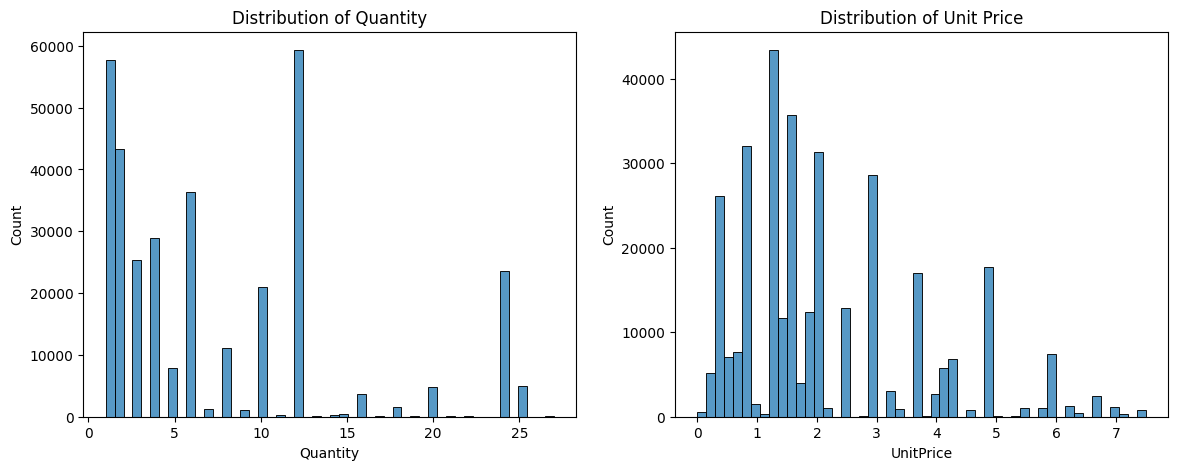

In [851]:
# Quantity and Unit Price Distribution(X= quantity/ Price , Y= No of transactions)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["Quantity"], bins=50, ax=ax[0])
ax[0].set_title("Distribution of Quantity")

sns.histplot(df["UnitPrice"], bins=50, ax=ax[1])
ax[1].set_title("Distribution of Unit Price")
plt.show()


**Correlation Heatmap**

A correlation heatmap helps identify relationships among numerical features — useful for later modeling.

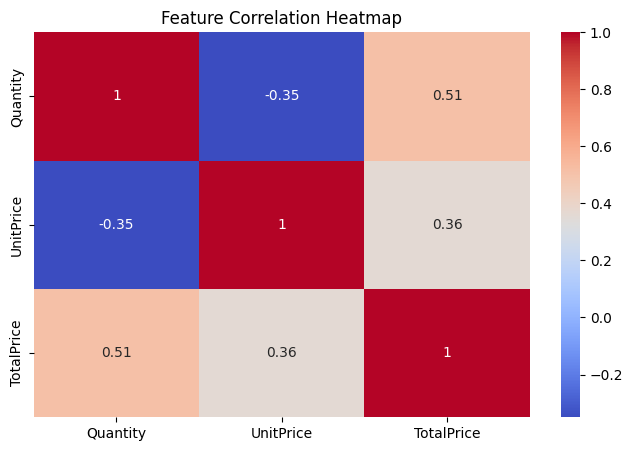

In [852]:
plt.figure(figsize=(8,5))
sns.heatmap(df[["Quantity", "UnitPrice", "TotalPrice"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


**Top 10 Countries by Transactions**

A high-level look at which countries contribute most to transactions.

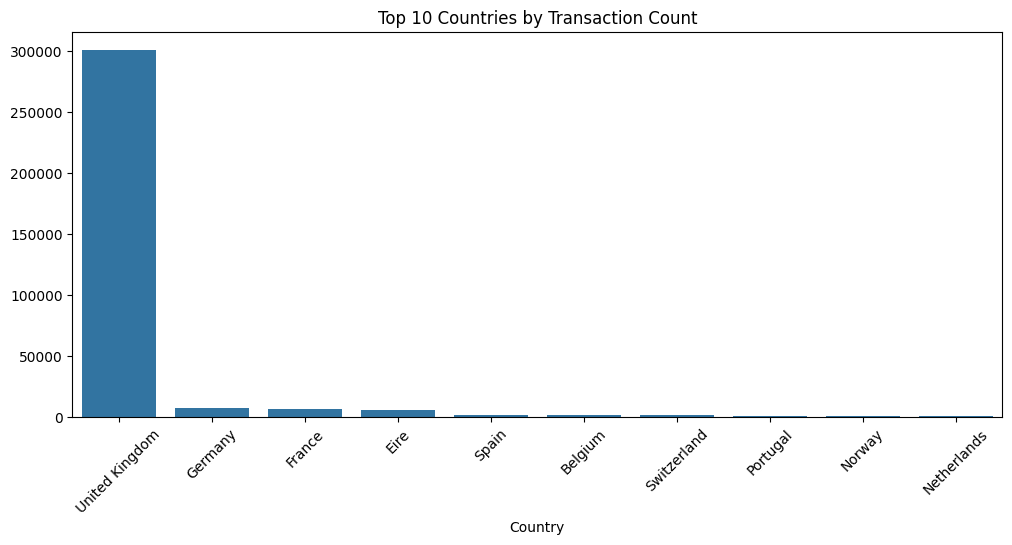

In [853]:
plt.figure(figsize=(12,5))
sns.barplot(x=df["Country"].value_counts().head(10).index,
            y=df["Country"].value_counts().head(10).values)
plt.title("Top 10 Countries by Transaction Count")
plt.xticks(rotation=45)
plt.show()


**Top 5 Best-Selling Products**

Shows which items are most frequently sold, helping understand demand concentration.

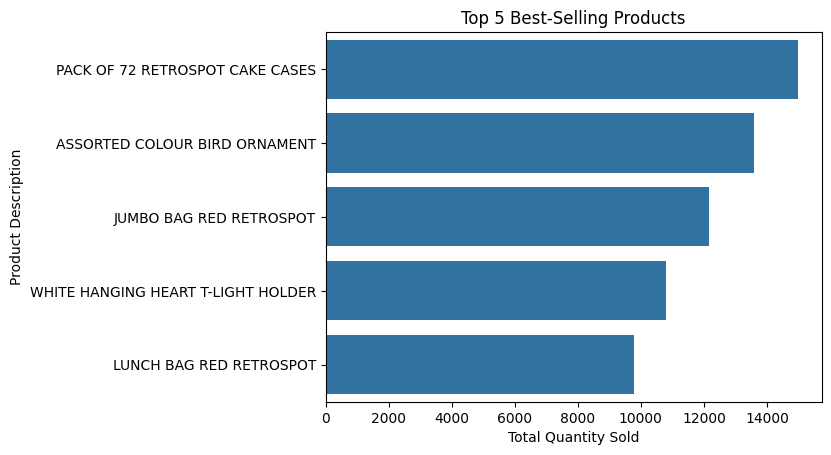

In [854]:
top_products = df.groupby("Description")["Quantity"].sum().nlargest(5)
sns.barplot(y=top_products.index, x=top_products.values)
plt.title("Top 5 Best-Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()


**Top 5 Highest Revenue Products**

Highlights which items generate the most sales revenue.

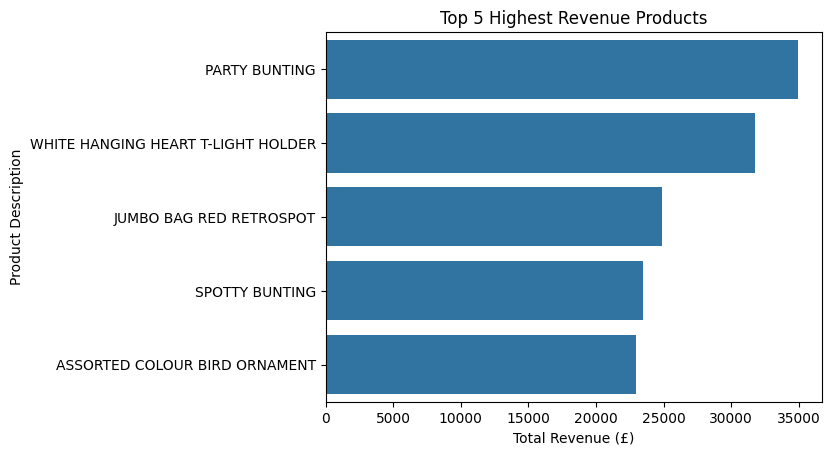

In [855]:
top_revenue = df.groupby("Description")["TotalPrice"].sum().nlargest(5)
sns.barplot(y=top_revenue.index, x=top_revenue.values)
plt.title("Top 5 Highest Revenue Products")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Product Description")
plt.show()


**Top 5 Countries by Revenue**

Visualizing the top revenue-generating countries highlights core markets.

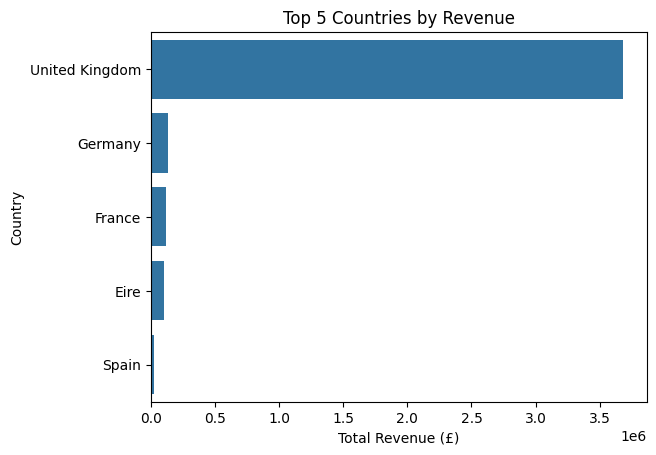

In [856]:
top_countries = df.groupby("Country")["TotalPrice"].sum().nlargest(5)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 5 Countries by Revenue")
plt.xlabel("Total Revenue (£)")
plt.ylabel("Country")
plt.show()


**Top 5 Customers by Spend**

Identifying top-spending customers offers early insights for loyalty analysis.

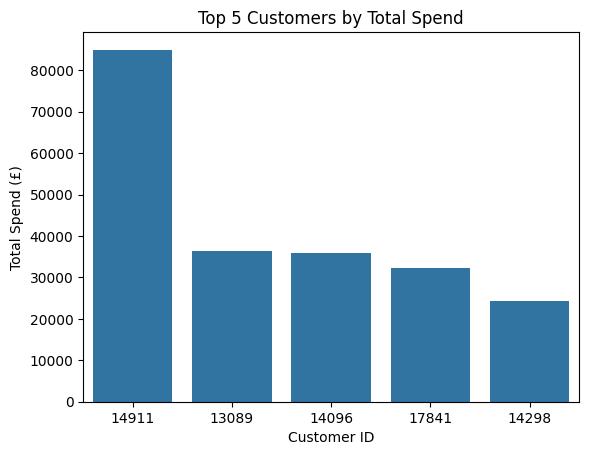

In [857]:
top_customers = df.groupby("CustomerID")["TotalPrice"].sum().nlargest(5)
sns.barplot(x=top_customers.index.astype(str), y=top_customers.values)
plt.title("Top 5 Customers by Total Spend")
plt.xlabel("Customer ID")
plt.ylabel("Total Spend (£)")
plt.show()


**Monthly Sales Trend**

Shows total revenue trends over months — useful for seasonality detection.

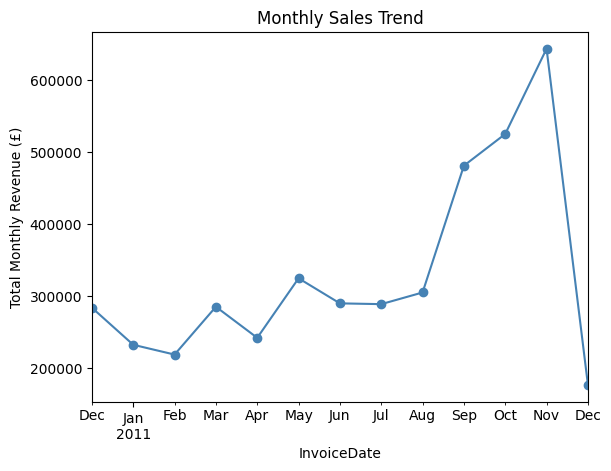

In [858]:
monthly_sales = df.groupby(df["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum()
monthly_sales.plot(kind="line", marker="o", title="Monthly Sales Trend", color="steelblue")
plt.ylabel("Total Monthly Revenue (£)")
plt.show()


**Hourly Purchase Pattern**

Shows when customers are most active during the day.

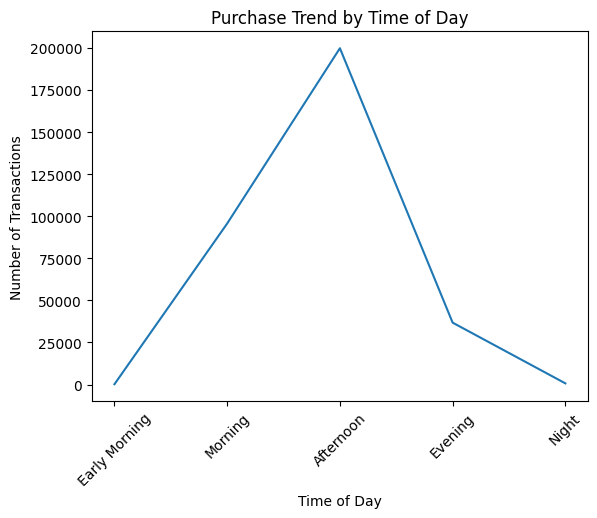

In [859]:
def get_time_of_day(hour):
    if 4 <= hour <= 7:
        return "Early Morning"
    elif 8 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 15:
        return "Afternoon"
    elif 16 <= hour <= 19:
        return "Evening"
    elif 20 <= hour <= 23:
        return "Night"
    else:
        return "Late Night"

df["TimeOfDay"] = df["Hour"].apply(get_time_of_day)



tod_counts = df["TimeOfDay"].value_counts().reindex(
    ["Late Night", "Early Morning", "Morning", "Afternoon", "Evening", "Night"]
)



sns.lineplot(x=tod_counts.index, y=tod_counts.values)
plt.title("Purchase Trend by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()



**Day-of-Week Sales Distribution**

Indicates the busiest shopping days.

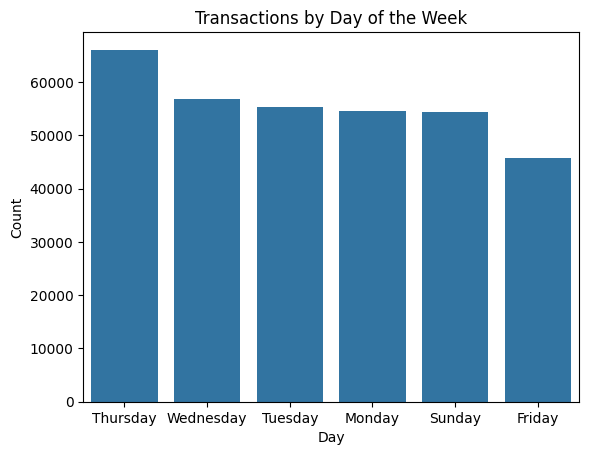

In [860]:
sns.barplot(x=df["DayOfWeek"].value_counts().index,
            y=df["DayOfWeek"].value_counts().values)
plt.title("Transactions by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()


**Average Basket Size per Country**

Compares the average transaction value across countries — excellent for market insights.

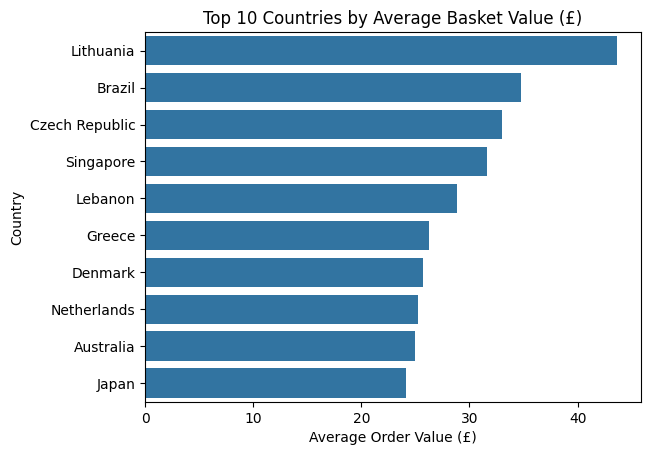

In [861]:
basket = df.groupby("Country")["TotalPrice"].mean().nlargest(10)
sns.barplot(y=basket.index, x=basket.values)
plt.title("Top 10 Countries by Average Basket Value (£)")
plt.xlabel("Average Order Value (£)")
plt.ylabel("Country")
plt.show()


**Sales Activity Heatmap (Day of Week vs. Hour)**

Instead of looking at "Day" and "Hour" separately, combining them tells you exactly when your store is busiest (e.g., "Wednesday & Thursday afternoons are peak time").


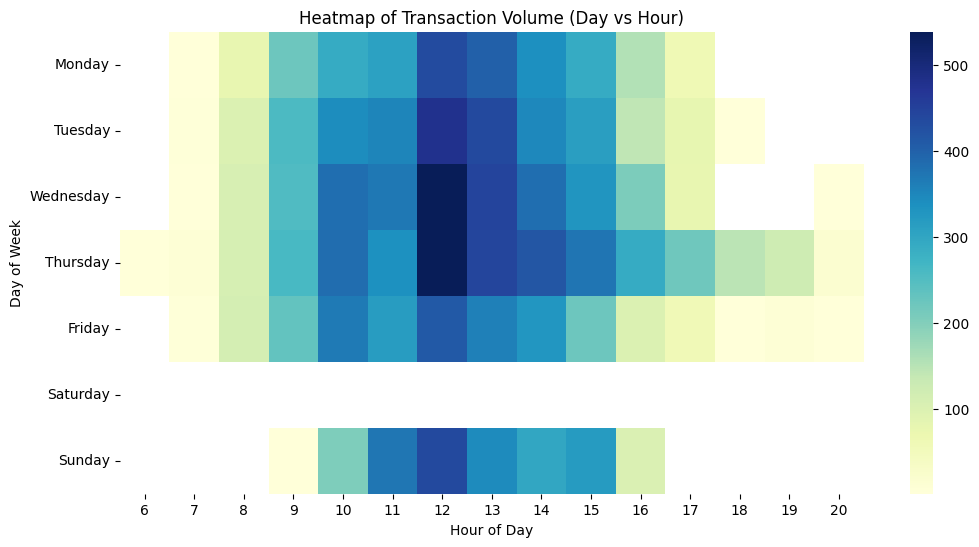

In [862]:
activity_pivot = df.groupby(['DayOfWeek', 'Hour'])['InvoiceNo'].nunique().unstack()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
activity_pivot = activity_pivot.reindex(days_order)

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(activity_pivot, cmap='YlGnBu', annot=False, fmt='g')
plt.title('Heatmap of Transaction Volume (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

**Word Cloud of Product Descriptions**

To instantly visualize the most common types of products you sell (e.g., "Vintage", "Bag", "Cake", "Christmas") without reading thousands of rows.

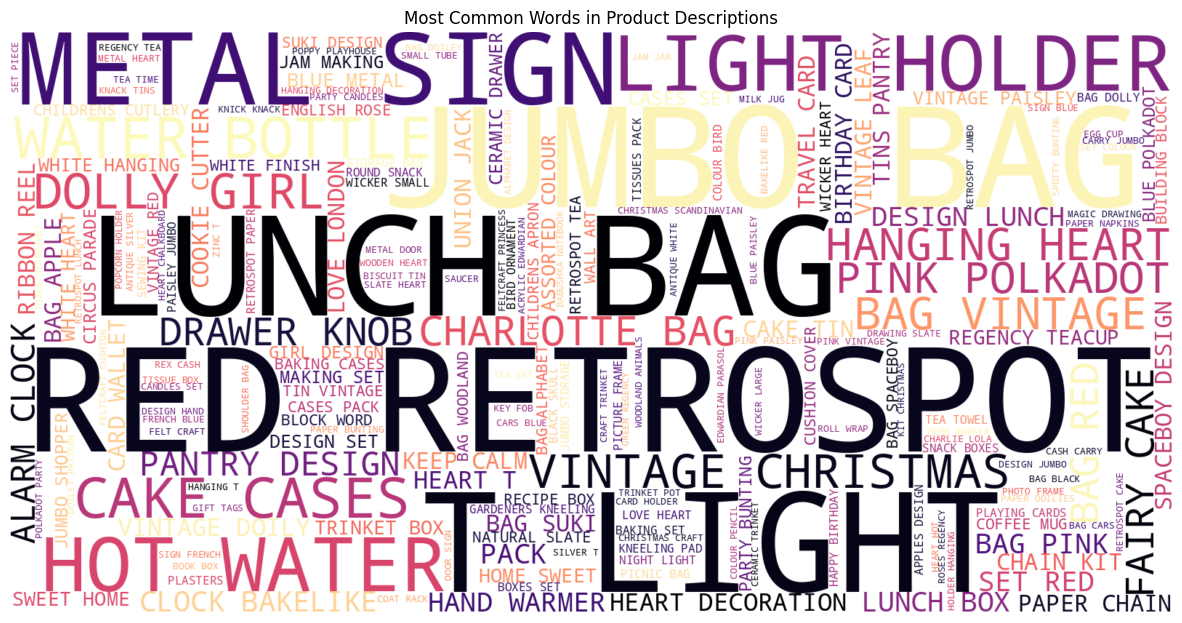

In [863]:
from wordcloud import WordCloud

# Combined all descriptions into one large string
text = " ".join(description for description in df.Description.astype(str))

# Generated Word Cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='magma').generate(text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Product Descriptions")
plt.show()

**Customer Retention (Cohort Analysis)**

This is one of the most valuable metrics for any business. It answers: "Of the customers who joined in January, how many came back in February?"

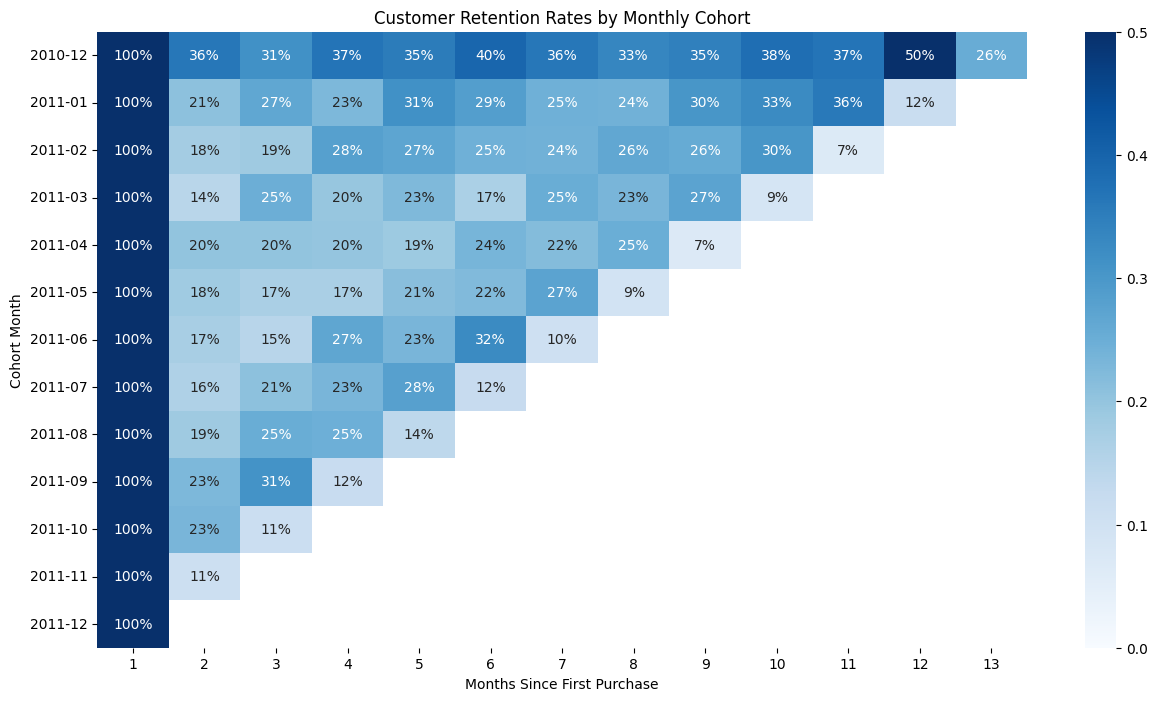

In [864]:
#Assign Cohort Month (Month of first purchase for each customer)
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

#Calculate the cohort index (Months since first purchase)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues', vmin=0.0, vmax=0.5)
plt.title('Customer Retention Rates by Monthly Cohort')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()

**RFM Analysis Distributions (Recency, Frequency, Monetary)**

To understand your customer base's quality.

Recency: How recently did they buy?

Frequency: How often do they buy?

Monetary: How much do they spend?

In [865]:
# ================================================
#  RFM ANALYSIS – Customer Segmentation
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

reference_date = df['InvoiceDate'].max()

print(f"Dataset period          : {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
print(f"RFM Reference Date      : {reference_date.date()} (last transaction date)\n")

# Build RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency in days
    'InvoiceNo'  : 'nunique',                                   # Frequency = number of orders
    'TotalPrice' : 'sum'                                        # Monetary = total spent
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm = rfm[rfm['Monetary'] > 0]

print(f"Final Customers in RFM Analysis: {rfm.shape[0]:,}")
rfm.head()

Dataset period          : 2010-12-01 to 2011-12-09
RFM Reference Date      : 2011-12-09 (last transaction date)

Final Customers in RFM Analysis: 4,191


,CustomerID,Recency,Frequency,Monetary
0,12347,1,7,3314.73
1,12348,248,3,90.20
2,12349,18,1,999.15
3,12350,309,1,294.40
4,12352,35,7,1130.94


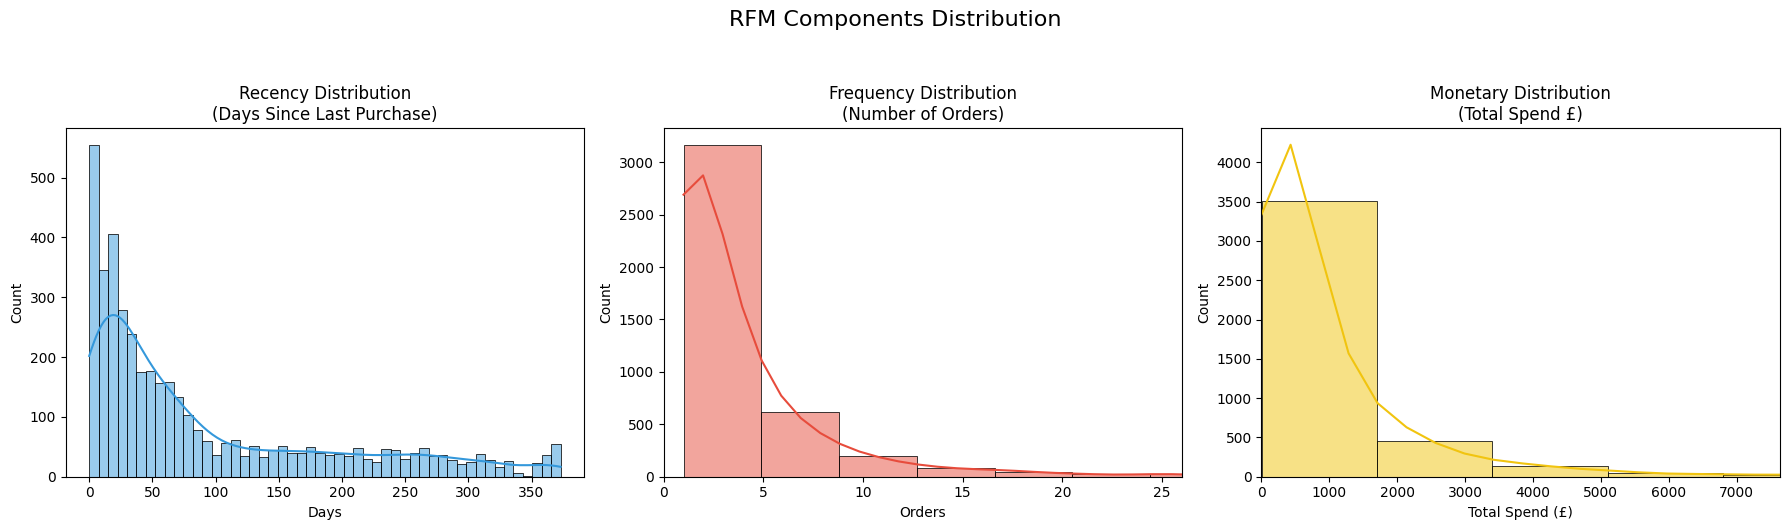

In [866]:
# Distribution of Recency, Frequency, Monetary
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=50, kde=True, color='#3498db', ax=axes[0])
axes[0].set_title('Recency Distribution\n(Days Since Last Purchase)')
axes[0].set_xlabel('Days')

sns.histplot(rfm['Frequency'], bins=50, kde=True, color='#e74c3c', ax=axes[1])
axes[1].set_title('Frequency Distribution\n(Number of Orders)')
axes[1].set_xlabel('Orders')
axes[1].set_xlim(0, rfm['Frequency'].quantile(0.99))

sns.histplot(rfm['Monetary'], bins=50, kde=True, color='#f1c40f', ax=axes[2])
axes[2].set_title('Monetary Distribution\n(Total Spend £)')
axes[2].set_xlabel('Total Spend (£)')
axes[2].set_xlim(0, rfm['Monetary'].quantile(0.99))

plt.suptitle('RFM Components Distribution', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [867]:
# Assign RFM Scores (1-5 scale)
# Recency: lower days = better → reverse scoring
# Frequency & Monetary: higher = better

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Value'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).astype(int)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Value
0,12347,1,7,3314.73,5,5,5,555,15
1,12348,248,3,90.20,1,3,1,131,5
2,12349,18,1,999.15,4,1,4,414,9
3,12350,309,1,294.40,1,1,2,112,4
4,12352,35,7,1130.94,3,5,4,354,12


/tmp/ipython-input-730274756.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




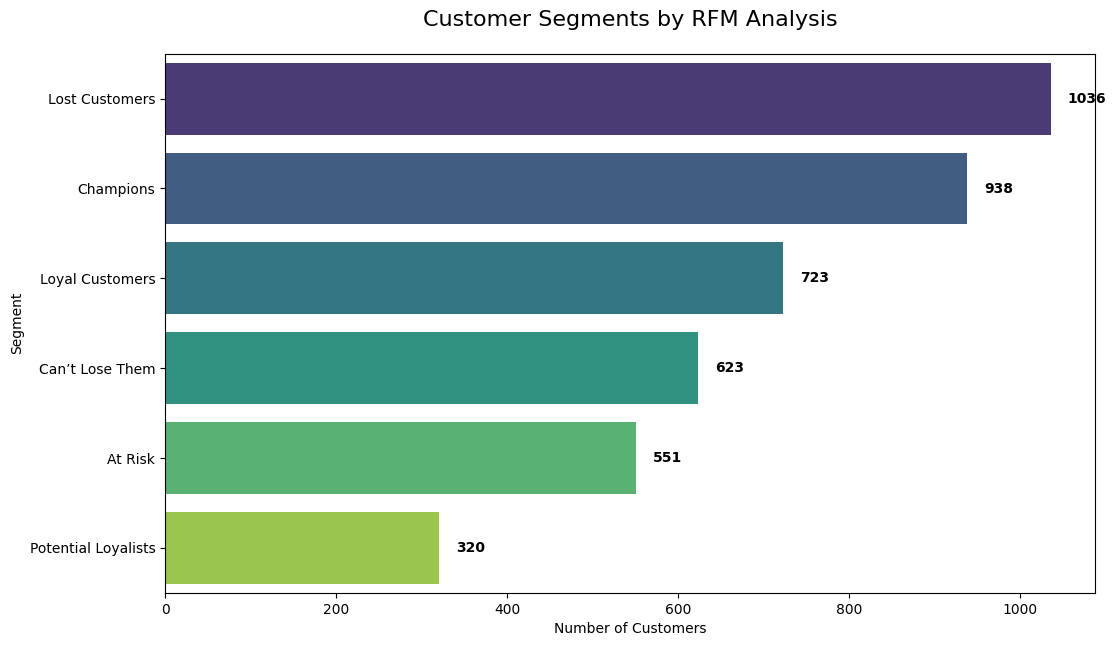

Segment
Lost Customers         1036
Champions               938
Loyal Customers         723
Can’t Lose Them         623
At Risk                 551
Potential Loyalists     320
Name: count, dtype: int64


In [868]:
# Customer Segmentation with Clear Business Labels
def assign_segment(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    m = int(row['M_Score'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f >= 2:
        return 'Potential Loyalists'
    elif r >= 3 and f >= 1:
        return 'At Risk'
    elif r <= 2 and f >= 3:
        return 'Can’t Lose Them'
    elif r <= 2 and f <= 2:
        return 'Lost Customers'
    elif r >= 4 and f == 1:
        return 'Recent/New Customers'
    else:
        return 'Low Value'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Visualize segments
plt.figure(figsize=(12, 7))
segment_order = rfm['Segment'].value_counts().index
sns.countplot(data=rfm, y='Segment', order=segment_order, palette='viridis')
plt.title('Customer Segments by RFM Analysis', fontsize=16, pad=20)
plt.xlabel('Number of Customers')
for i, v in enumerate(rfm['Segment'].value_counts()[segment_order]):
    plt.text(v + 20, i, str(v), va='center', fontweight='bold')
plt.show()

print(rfm['Segment'].value_counts())

In [869]:
# Top 10 Most Valuable Customers
print("Top 10 High-Value Customers (Champions + Loyal)")
top_10 = rfm.sort_values('Monetary', ascending=False).head(10).copy()
top_10['Monetary'] = top_10['Monetary'].round(2)
top_10[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']]

Top 10 High-Value Customers (Champions + Loyal)


,CustomerID,Recency,Frequency,Monetary,RFM_Score,Segment
1828,14911,0,193,84980.89,555,Champions
542,13089,3,80,36347.88,555,Champions
1251,14096,3,17,36019.84,555,Champions
3885,17841,1,123,32224.59,555,Champions
1392,14298,7,40,24387.53,555,Champions
323,12748,0,196,20519.88,555,Champions
1293,14156,9,41,18276.11,555,Champions
538,13081,11,10,17925.53,555,Champions
2113,15311,0,91,17712.96,555,Champions
1247,14088,9,12,15700.62,555,Champions


In [870]:
# Final Business Summary
total_revenue = rfm['Monetary'].sum()
champions_revenue = rfm[rfm['Segment']=='Champions']['Monetary'].sum()

print("="*60)
print("RFM ANALYSIS – KEY BUSINESS INSIGHTS")
print("="*60)
print(f"Total Customers             : {rfm.shape[0]:,}")
print(f"Total Revenue (from these)  : £{total_revenue:,.2f}")
print(f"Champions (Best Customers)  : {rfm[rfm['Segment']=='Champions'].shape[0]:,} customers")
print(f"Revenue from Champions      : £{champions_revenue:,.2f} ({champions_revenue/total_revenue*100:.1f}% of total!)")
print(f"Average order value (top 10): £{rfm.nlargest(10, 'Monetary')['Monetary'].mean():,.0f}")
print(f"Customers who haven't bought in >180 days: {(rfm['Recency'] > 180).sum():,} → Reactivation campaigns!")
print(f"Lost customers              : {rfm[rfm['Segment']=='Lost Customers'].shape[0]:,}")
print("="*60)

RFM ANALYSIS – KEY BUSINESS INSIGHTS
Total Customers             : 4,191
Total Revenue (from these)  : £4,299,476.18
Champions (Best Customers)  : 938 customers
Revenue from Champions      : £2,619,319.32 (60.9% of total!)
Average order value (top 10): £30,410
Customers who haven't bought in >180 days: 829 → Reactivation campaigns!
Lost customers              : 1,036


**Export Cleaned Dataset**

The cleaned and preprocessed dataset is saved for downstream modeling and analysis.

In [871]:
df.to_csv("cleaned_online_retail.csv", index=False)
print("Cleaned dataset saved as cleaned_online_retail.csv")


Cleaned dataset saved as cleaned_online_retail.csv


# **Final Summary Statistics**

A final overview of dataset scope and key metrics after cleaning.


In [872]:
print("Final Dataset Summary:")
print(f"Total Rows: {df.shape[0]:,}")
print(f"Unique Customers: {df['CustomerID'].nunique():,}")
print(f"Unique Products: {df['Description'].nunique():,}")
print(f"Countries Covered: {df['Country'].nunique():,}")
print(f"Total Revenue: £{df['TotalPrice'].sum():,.2f}")


Final Dataset Summary:
Total Rows: 333,234
Unique Customers: 4,191
Unique Products: 3,575
Countries Covered: 37
Total Revenue: £4,299,476.18
